In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import maximum_filter
import math

In [2]:
def compute_integral_image(image):
    """
    Computes the integral image (summed area table).
    Args:
        image: Input image (grayscale, float32)
    Returns:
        S: Integral image where S[y,x] is the sum of all pixels 
           in the rectangle from (0,0) to (y,x).
    """
    temp_integral_image=np.cumsum(image,axis=0)
    integral_image=np.cumsum(temp_integral_image,axis=1)
    
    return integral_image

In [71]:
# def get_box_sum(integral_img, r1, c1, r2, c2):
#     """
#     Calculates sum of pixels in the rectangle defined by (r1, c1) top-left
#     and (r2, c2) bottom-right (INCLUSIVE).
#     """
#     D=integral_img[r2,c2]
    
#     if(r1>0):
#         B = integral_img[r1-1,c2]
#     else:
#         B = 0

#     if(c1>0):
#         C = integral_img[r2,c1-1]
#     else:
#         C = 0

#     if(r1>0 and c1>0):
#         A = integral_img[r1-1, c1-1]
#     else:
#         A = 0

#     box_sum = D - B - C + A
    
#     return box_sum


def get_box_sum(integral_img, r1, c1, r2, c2):
    """
    Calculates sum of pixels in the rectangle defined by (r1, c1) top-left
    and (r2, c2) bottom-right (INCLUSIVE).
    Includes boundary checks to prevent crashes.
    """
    h, w = integral_img.shape
    
    # --- SAFETY CHECK START ---
    # Force coordinates to be within the valid image range
    r1 = max(0, int(r1))
    c1 = max(0, int(c1))
    r2 = min(h - 1, int(r2)) # <--- This prevents the index 513 error!
    c2 = min(w - 1, int(c2))
    # --- SAFETY CHECK END ---
    
    # If the box is invalid (e.g. totally off-screen), return 0
    if r1 > r2 or c1 > c2:
        return 0

    D = integral_img[r2, c2]
    
    if r1 > 0:
        B = integral_img[r1 - 1, c2]
    else:
        B = 0

    if c1 > 0:
        C = integral_img[r2, c1 - 1]
    else:
        C = 0

    if r1 > 0 and c1 > 0:
        A = integral_img[r1 - 1, c1 - 1]
    else:
        A = 0

    box_sum = D - B - C + A
    
    return box_sum

In [32]:
# def compute_hessian_response(integral_img, r, c):
#     """
#     Computes Dxx, Dyy, Dxy for a pixel (r, c) using 9x9 box filters.
#     """
#     # 1. Calculate Dyy (Top +1, Mid -2, Bot +1)
#     top_sum = get_box_sum(integral_img, r-4, c-1, r-2, c+1)
#     mid_sum = get_box_sum(integral_img,r-1,c-1,r+1,c+1)
#     bot_sum = get_box_sum(integral_img,r+2,c-1,r+4,c+1)

#     Dyy = top_sum - (2 * mid_sum) + bot_sum
    
#     # 2. Calculate Dxx (Left +1, Mid -2, Right +1)
#     left_sum = get_box_sum(integral_img,r-1,c-4,r+1,c-2)
#     mid_sum = get_box_sum(integral_img,r-1,c-1,r+1,c+1)
#     right_sum = get_box_sum(integral_img,r-1,c+2,r+1,c+4)

#     Dxx = left_sum - (2 * mid_sum) + right_sum
    
#     # 3. Calculate Dxy (TL +1, TR -1, BL -1, BR +1)
#     top_left_sum=get_box_sum(integral_img,r-4,c-4,r-2,c-2)
#     top_right_sum=get_box_sum(integral_img,r-4,c+2,r-2,c+4)
#     botton_left_sum=get_box_sum(integral_img,r+2,c-4,r+4,c-2)
#     botton_right_sum=get_box_sum(integral_img,r+2,c+2,r+4,c+4)

#     Dxy = top_left_sum - top_right_sum - botton_left_sum + botton_right_sum
    
#     Determinant = (Dxx * Dyy) - (0.9 * Dxy) ** 2 
    
#     return Determinant

In [45]:
def compute_hessian_response(integral_img, filter_size, r, c):
    """
    Computes Dxx, Dyy, Dxy for a pixel (r, c) using dynamic box filters.
    """
    lobe = filter_size // 3
    half = lobe // 2       # For lobe=3, half=1. For lobe=5, half=2.

    # Calculate Area for Normalization
    filter_area = filter_size * filter_size
    
    # 1. Calculate Dyy (Top +1, Mid -2, Bot +1)
    # The vertical stack
    top_sum = get_box_sum(integral_img, r-half-lobe, c-half, r-half-1, c+half)
    mid_sum = get_box_sum(integral_img, r-half, c-half, r+half, c+half)
    bot_sum = get_box_sum(integral_img, r+half+1, c-half, r+half+lobe, c+half)

    # Dyy = top_sum - (2 * mid_sum) + bot_sum
    Dyy = (top_sum - (2 * mid_sum) + bot_sum)/filter_area
    
    
    # 2. Calculate Dxx (Left +1, Mid -2, Right +1)
    # The horizontal stack
    left_sum  = get_box_sum(integral_img, r-half, c-half-lobe, r+half, c-half-1)
    mid_sum   = get_box_sum(integral_img, r-half, c-half, r+half, c+half)
    right_sum = get_box_sum(integral_img, r-half, c+half+1, r+half, c+half+lobe)

    # Dxx = left_sum - (2 * mid_sum) + right_sum
    Dxx = (left_sum - (2 * mid_sum) + right_sum) / filter_area
    
    # 3. Calculate Dxy (TL +1, TR -1, BL -1, BR +1)
    # The diagonal corners
    top_left_sum     = get_box_sum(integral_img, r-half-lobe, c-half-lobe, r-half-1, c-half-1)
    top_right_sum    = get_box_sum(integral_img, r-half-lobe, c+half+1, r-half-1, c+half+lobe)
    bottom_left_sum  = get_box_sum(integral_img, r+half+1, c-half-lobe, r+half+lobe, c-half-1)
    bottom_right_sum = get_box_sum(integral_img, r+half+1, c+half+1, r+half+lobe, c+half+lobe)

    # Dxy = top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum
    Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area
    
    
    # Standard SURF determinant weight
    Determinant = (Dxx * Dyy) - (0.9 * Dxy) ** 2 
    
    return Determinant

In [39]:
def find_surf_keypoints(integral_img, threshold=2000,hessian_filter_size=9):
    """
    Scans the image and finds points with high Hessian response.
    """
    height, width = integral_img.shape
    # keypoints = []
    hessian_map=np.zeros(integral_img.shape, dtype=np.float32)
    
    # Margin for 9x9 filter is 4 pixels
    # margin = 4
    margin = hessian_filter_size // 2
    
    # Range should be from 'margin' to 'height - margin'
    for r in range(margin, height-margin):
        for c in range(margin, width-margin):
            # 1. Compute Hessian
            hessian_det=compute_hessian_response(integral_img,hessian_filter_size,r,c)
        
            # 2. Check Threshold
            if(hessian_det>threshold):
                # keypoints.append((c,r,hessian_det))
                hessian_map[r,c]=hessian_det
            
    # return keypoints
    return hessian_map

In [ ]:
# hessian_map = find_surf_keypoints(integral_img)
# local_max= maximum_filter(hessian_map,size=3)
# boolean_mask= False

# is_max_local=((hessian_map == local_max) & (local_max > 0))

# rows, cols = np.where(is_max_local)

# final_keypoints=[]

# for r,c in zip(rows,cols):
#     det=hessian_map[r,c]
#     final_keypoints.append((c,r,det))
    

In [64]:
def detect_surf_features(integral_img, threshold=2000, local_max_size_filter=3,hessian_filter_size=9):
    """
    Detects SURF features using a Hessian blob detector.

    Args:
        integral_img: The integral image (2D numpy array).
        threshold: Value to filter out weak blobs (default 2000).
        filter_size: Size of the neighborhood for NMS (default 3).

    Returns:
        final_keypoints: A list of tuples (x, y, determinant).
    """

    # 1. Calculating the current scale of the filter
    current_scale = 1.2 * (hessian_filter_size/9)
    
    # 2. Compute the Hessian response map
    hessian_map = find_surf_keypoints(integral_img,threshold=threshold,hessian_filter_size=hessian_filter_size)
    
    # 3. Find local maxima in the map using the scipy.ndimage.maximum_filter
    local_max= maximum_filter(hessian_map,size=local_max_size_filter)

    # 4. Create a boolean mask for valid keypoints
    boolean_mask= False
    is_max_local=((hessian_map == local_max) & (local_max > 0))

    # 5. Extract the coordinates (rows, cols) where the mask is True
    rows, cols = np.where(is_max_local)

    # 6. Convert to the final list of keypoints
    final_keypoints=[]

    for r,c in zip(rows,cols):
        det=hessian_map[r,c]
        final_keypoints.append((c,r,current_scale,det))

    return final_keypoints

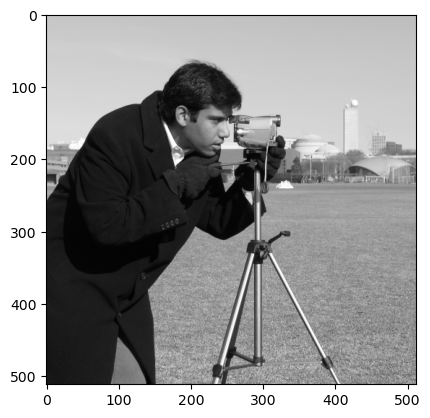

In [11]:
from skimage import data
test_img = data.camera()
plt.imshow(test_img,cmap='gray')

/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar subtract
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar add
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/3013075452.py:38: RuntimeWarning: overflow encountered in scalar subtract
  Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/3013075452.py:38: RuntimeWarning: overflow encountered in scalar add
  Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area


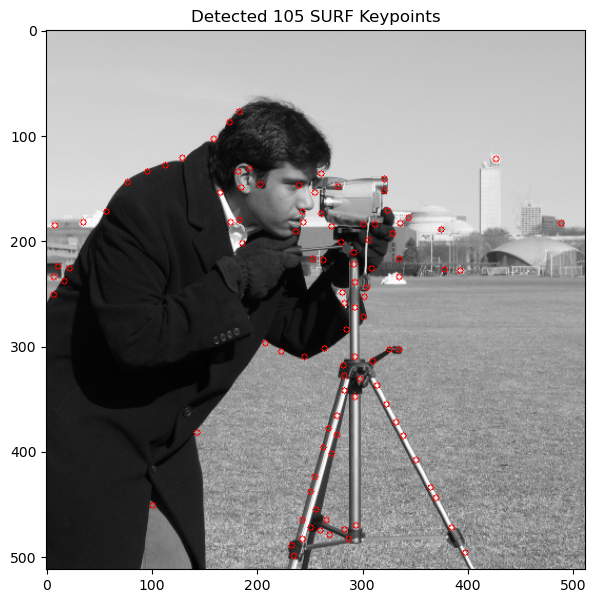

In [56]:
# 1. Compute Integral Image
integral_test_image = compute_integral_image(test_img)

# 2. Find Keypoints
keypoints = detect_surf_features(integral_test_image, threshold=50, hessian_filter_size=15, local_max_size_filter=15)

rgb_image = cv2.cvtColor(test_img, cv2.COLOR_GRAY2RGB)

# 4. Draw Circles
for x, y, det in keypoints:
    cv2.circle(rgb_image, (x, y), 3, (255, 0, 0), 1)

# 5. Display
plt.figure(figsize=(7, 7))
plt.imshow(rgb_image)
plt.title(f"Detected {len(keypoints)} SURF Keypoints")
plt.show()

In [55]:
# Let's peek at the max value in your Hessian Map to gauge the threshold
temp_hessian = find_surf_keypoints(integral_test_image, threshold=0, hessian_filter_size=15)
max_val = np.max(temp_hessian)
avg_val = np.mean(temp_hessian[temp_hessian > 0])

print(f"Maximum Hessian Response: {max_val}")
print(f"Average Response (of non-zero): {avg_val}")
print(f"Suggested Threshold (approx 50% of max): {max_val * 0.5}")

/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar subtract
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar add
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/3013075452.py:38: RuntimeWarning: overflow encountered in scalar subtract
  Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/3013075452.py:38: RuntimeWarning: overflow encountered in scalar add
  Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area


Maximum Hessian Response: 535.6187744140625
Average Response (of non-zero): 6.14957332611084
Suggested Threshold (approx 50% of max): 267.80938720703125


/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar subtract
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar add
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/3013075452.py:38: RuntimeWarning: overflow encountered in scalar subtract
  Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/3013075452.py:38: RuntimeWarning: overflow encountered in scalar add
  Dxy = (top_left_sum - top_right_sum - bottom_left_sum + bottom_right_sum) / filter_area


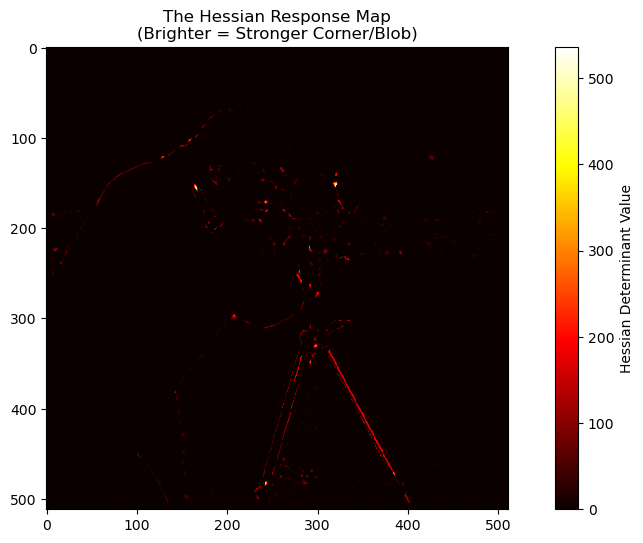

In [59]:
import matplotlib.pyplot as plt

# 1. Re-calculate the map (just to be safe)
# We use threshold=0 because we want to see the FULL map, not just the winners.
hessian_map = find_surf_keypoints(integral_test_image, threshold=0, hessian_filter_size=15)

# 2. Plotting
plt.figure(figsize=(12, 6))

# Use 'hot' or 'jet' colormap so high numbers look like "fire" or "red zones"
plt.imshow(hessian_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Hessian Determinant Value')
plt.title("The Hessian Response Map\n(Brighter = Stronger Corner/Blob)")
plt.show()

In [62]:
def get_haar_x(integral_img, r, c, size):
    """
    Calculates Haar Wavelet response in X direction.
    (Left half is negative, Right half is positive)
    """
    half = size // 2
    
    # Left Box (Negative weight)
    # r-half to r+half (height is full size)
    # c-half to c (width is half size)
    left_sum = get_box_sum(integral_img, r-half, c-half, r+half, c)
    
    # Right Box (Positive weight)
    # r-half to r+half (height is full size)
    # c+1 to c+half (width is half size)
    right_sum = get_box_sum(integral_img, r-half, c+1, r+half, c+half)
    
    # return right_sum - left_sum
    return float(right_sum) - float(left_sum)

def get_haar_y(integral_img, r, c, size):
    """
    Calculates Haar Wavelet response in Y direction.
    (Top half is negative, Bottom half is positive)
    """
    half = size // 2
    
    # Top Box (Negative weight)
    top_sum = get_box_sum(integral_img, r-half, c-half, r, c+half)
    
    # Bottom Box (Positive weight)
    bot_sum = get_box_sum(integral_img, r+1, c-half, r+half, c+half)
    
    # return bot_sum - top_sum
    return float(bot_sum) - float(top_sum)

In [63]:
# 1. Grab the first keypoint from your results
first_keypoint = keypoints[0]

# 2. Unpack the values (Remember: your function returns c, r, det)
c_loc, r_loc, det = first_keypoint

# 3. Call the function
# We use size=8 because for filter_size=15, the scale is roughly 2.0.
# Standard SURF sets wavelet size = 4 * scale (so 4 * 2 = 8).
response_x = get_haar_x(integral_test_image, int(r_loc), int(c_loc), size=8)

print(f"Haar X Response at ({c_loc}, {r_loc}): {response_x}")

Haar X Response at (183, 77): -3209.0


/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar subtract
  box_sum = D - B - C + A
/var/folders/rv/41rmt3f941bdz6fjkvr14hvm0000gn/T/ipykernel_47973/4168962763.py:23: RuntimeWarning: overflow encountered in scalar add
  box_sum = D - B - C + A


In [65]:
def get_surf_descriptor(integral_img, keypoint, angle):
    # keypoint is (c, r, scale, response)
    # angle is the orientation in radians
    
    # Initialize descriptor
    descriptor = np.zeros(64)

    #Initializing the singma for gaussian blur
    sigma = 3.3 * keypoint[2]

    for i in range(4):
        for j in range(4):
            for sample_r in range(5):
                for sample_c in range(5):
                    # Calculate coordinates relative to the center (if angle was 0)
                    # We subtract 9.5 to center the 0-19 grid around 0
                    c_unrotated = ((j * 5 + sample_c) - 9.5) * keypoint[2] 
                    r_unrotated = ((i * 5 + sample_r) - 9.5) * keypoint[2]

                    weight=math.e ** -(((c_unrotated**2) + (r_unrotated ** 2)) / (2*sigma**2))

                    c_rot = (c_unrotated * math.cos(angle)) - (r_unrotated * math.sin(angle))
                    r_rot = (c_unrotated * math.sin(angle)) + (r_unrotated * math.cos(angle))

                    real_c = keypoint[0] + c_rot
                    real_r = keypoint[1] + r_rot

                    raw_dx = get_haar_x(integral_img,int(real_r),int(real_c),2 * int(keypoint[2]))
                    raw_dy = get_haar_y(integral_img,int(real_r),int(real_c),2 * int(keypoint[2]))

                    rot_dx = raw_dx * math.cos(angle) + raw_dy * math.sin(angle)
                    rot_dy = - raw_dx * math.sin(angle) + raw_dy * math.cos(angle)
                    
                    base_index = (i * 4 + j) * 4

                    descriptor[base_index]+=weight * rot_dx
                    descriptor[base_index+1]+=weight * rot_dy
                    descriptor[base_index+2]+=weight * abs(rot_dx)
                    descriptor[base_index+3]+=weight * abs(rot_dy)
                    
    magnitude = np.linalg.norm(descriptor)

    if magnitude>0:
        descriptor=descriptor/magnitude

    return descriptor

In [68]:
import numpy as np

def match_features(descriptors1, keypoints1, descriptors2, keypoints2, ratio_threshold=0.75):
    """
    Matches features from Image 1 to Image 2 using Euclidean distance and the Ratio Test.
    
    Args:
        descriptors1: List of 64-dim arrays for Image 1
        keypoints1: List of keypoint tuples (c, r, scale, response) for Image 1
        descriptors2: List of 64-dim arrays for Image 2
        keypoints2: List of keypoint tuples (c, r, scale, response) for Image 2
        ratio_threshold: The threshold for Lowe's ratio test (default 0.75)
        
    Returns:
        good_matches: List of tuples. Each tuple is:
                      ((c2, r2), r1, c1) 
                      This format is ready for our visualization function.
    """
    good_matches = []

    # Loop through every feature in the first image
    for i, d1 in enumerate(descriptors1):
        best_dist = float('inf')
        second_best = float('inf')
        best_idx = -1
        
        # Compare against every feature in the second image
        for j, d2 in enumerate(descriptors2):
            # Calculate Euclidean distance
            diff = d1 - d2
            dist = np.linalg.norm(diff)
            
            # Update best and second-best
            if dist < best_dist:
                second_best = best_dist
                best_dist = dist
                best_idx = j
            elif dist < second_best:
                second_best = dist
                
        # Apply Lowe's Ratio Test
        # We check if second_best is not 0 to avoid division by zero errors 
        # (though unlikely with floats)
        if second_best > 0 and (best_dist / second_best) < ratio_threshold:
            
            # Retrieve the coordinate information
            # keypoint1 is (c, r, scale, response), so we grab index 0 (c) and 1 (r)
            kp1_c = keypoints1[i][0]
            kp1_r = keypoints1[i][1]
            
            # The matching candidate in Image 2
            match_candidate = keypoints2[best_idx]
            kp2_c = match_candidate[0]
            kp2_r = match_candidate[1]
            
            # Store in the format: (Keypoint_In_Img2, Original_Row, Original_Col)
            # This matches the structure we used in our visualization code earlier
            match_tuple = ((kp2_c, kp2_r), kp1_r, kp1_c)
            good_matches.append(match_tuple)

    return good_matches

In [77]:
def get_dominant_orientation(integral_img, r, c, scale):
    """
    Calculates the dominant orientation of a keypoint.
    Returns: angle in radians.
    """
    # 1. Constants per SURF paper
    radius = 6 * scale
    haar_size = 4 * scale
    step = int(scale) # Sample every 'scale' pixels
    
    # 2. Collect gradients within the circular radius
    responses = []
    
    # Scan a square box around the keypoint, then check radius
    r_min = int(r - radius)
    r_max = int(r + radius)
    c_min = int(c - radius)
    c_max = int(c + radius)
    
    for check_r in range(r_min, r_max, step):
        for check_c in range(c_min, c_max, step):
            # Circle check: is point within radius?
            if (check_r - r)**2 + (check_c - c)**2 < radius**2:
                
                # Compute Haar response (using your existing functions)
                dx = get_haar_x(integral_img, check_r, check_c, int(haar_size))
                dy = get_haar_y(integral_img, check_r, check_c, int(haar_size))
                
                # Gaussian Weight (closer to center = more important)
                # sigma = 2.5 * scale
                dist_sq = (check_r - r)**2 + (check_c - c)**2
                weight = math.exp(-dist_sq / (2 * (2.5 * scale)**2))
                
                responses.append((dx * weight, dy * weight))

    # 3. Sliding Window (Sector of pi/3 or 60 degrees)
    # We want to find the vector sum with the largest magnitude
    if not responses:
        return 0.0

    best_angle = 0.0
    max_magnitude = 0.0
    
    # We test angles from 0 to 2*pi in small steps (e.g., 5 degrees or ~0.1 radians)
    # Optimization: Real SURF sorts responses by angle, but this loop is easier to read.
    check_angles = np.arange(0, 2*np.pi, 0.15) 
    
    window_size = np.pi / 3  # 60 degrees
    
    for angle in check_angles:
        sum_dx = 0
        sum_dy = 0
        
        # Check which responses fall into this window
        # (This is the brute-force way; optimized way uses sorting)
        # To simplify: We just project all vectors onto this direction 
        # But proper SURF sums vectors that strictly fall in the window.
        
        # SIMPLIFIED ROBUST METHOD:
        # Just summing vectors is tricky because of the window check.
        # Let's use a simpler heuristic for this custom implementation:
        # Rotate all vectors by -angle, sum those with Y within a small range?
        # No, let's stick to the definition: Sum vectors whose orientation is within [angle, angle + 60]
        
        for dx, dy in responses:
            # Calculate angle of this specific gradient
            orientation = math.atan2(dy, dx)
            if orientation < 0: orientation += 2*math.pi
            
            # Check if it falls in our sliding window
            # Handle wrap-around (e.g. window goes from 350 to 10 degrees)
            diff = orientation - angle
            if diff < 0: diff += 2*math.pi
            
            if diff < window_size:
                sum_dx += dx
                sum_dy += dy
        
        # Calculate magnitude of the sum
        magnitude = sum_dx**2 + sum_dy**2
        
        if magnitude > max_magnitude:
            max_magnitude = magnitude
            best_angle = math.atan2(sum_dy, sum_dx)

    return best_angle

1. Loading Image...
2. Creating Rotated Version...
3. Computing Integral Images...
4. Detecting Features (this may take a moment)...
   -> Found 107 features in Image 1
   -> Found 104 features in Image 2
5. Computing Descriptors...
6. Matching Features...
   -> Found 26 good matches!
7. Visualizing...


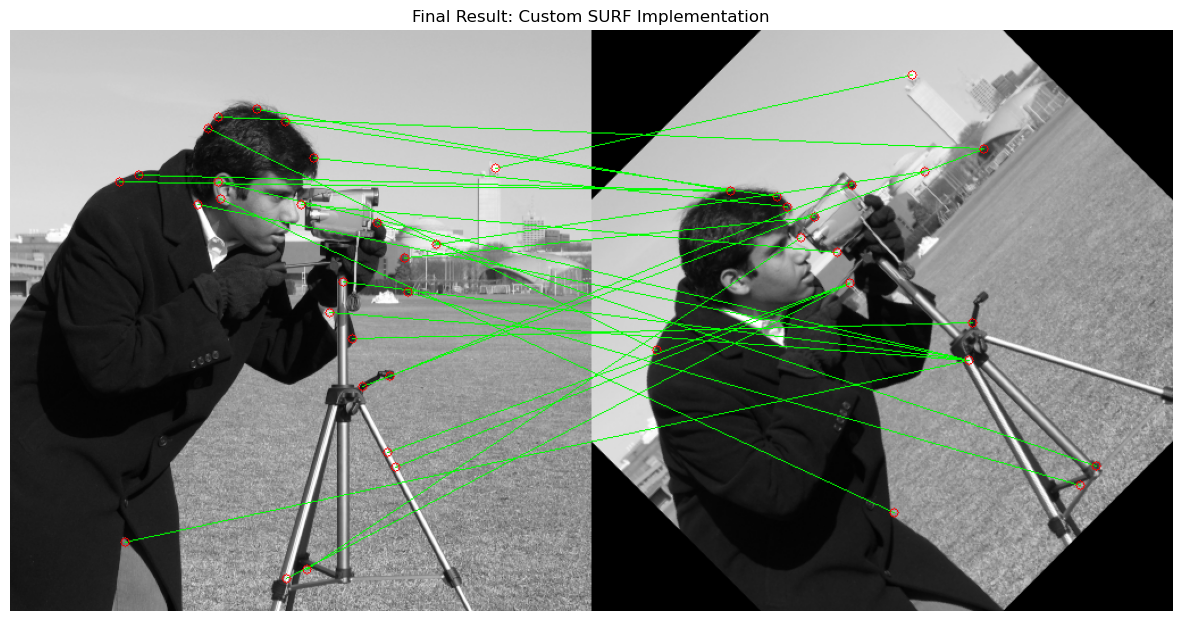

In [84]:
# A. Load Image
print("1. Loading Image...")
image = data.camera() # 512x512 grayscale
rows, cols = image.shape

# B. Create Rotated Version (45 degrees)
print("2. Creating Rotated Version...")
M = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1)
image_rot = cv2.warpAffine(image, M, (cols, rows))

# C. Compute Integral Images
print("3. Computing Integral Images...")
ii1 = compute_integral_image(image.astype(np.float32))
ii2 = compute_integral_image(image_rot.astype(np.float32))

# D. Detect Features
print("4. Detecting Features (this may take a moment)...")
# Note: Using high threshold to pick only strongest points for speed/clarity
# kps1 = detect_surf_features(ii1, threshold=5000) 
# kps2 = detect_surf_features(ii2, threshold=5000)
kps1 = detect_surf_features(ii1, threshold=50, hessian_filter_size=15, local_max_size_filter=15)
kps2 = detect_surf_features(ii2, threshold=50, hessian_filter_size=15, local_max_size_filter=15)
print(f"   -> Found {len(kps1)} features in Image 1")
print(f"   -> Found {len(kps2)} features in Image 2")

# E. Compute Descriptors
print("5. Computing Descriptors...")
# We use 0 rad for Image 1, and 45 deg (in rad) for Image 2
# descs1 = [get_surf_descriptor(ii1, kp, 0) for kp in kps1]
# descs2 = [get_surf_descriptor(ii2, kp, -np.radians(45)) for kp in kps2]
descs1 = []
for kp in kps1:
    # kp is (c, r, scale, response)
    c, r, scale = kp[0], kp[1], kp[2]
    
    # Calculate dominant orientation automatically!
    # Note: get_dominant_orientation expects (integral_img, r, c, scale)
    angle = get_dominant_orientation(ii1, r, c, scale)
    
    # Generate descriptor using this dynamic angle
    d = get_surf_descriptor(ii1, kp, angle)
    descs1.append(d)

# 2. Process Image 2
descs2 = []
for kp in kps2:
    c, r, scale = kp[0], kp[1], kp[2]
    
    # This will automatically find the ~45 degree rotation
    angle = get_dominant_orientation(ii2, r, c, scale)
    
    d = get_surf_descriptor(ii2, kp, angle)
    descs2.append(d)

# F. Match
print("6. Matching Features...")
matches = match_features(descs1, kps1, descs2, kps2, ratio_threshold=0.8)
print(f"   -> Found {len(matches)} good matches!")

# G. Visualize
print("7. Visualizing...")
vis_h = max(rows, rows)
vis_w = cols + cols
vis = np.zeros((vis_h, vis_w, 3), dtype=np.uint8)

# Place images side-by-side
vis[:rows, :cols] = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
vis[:rows, cols:] = cv2.cvtColor(image_rot, cv2.COLOR_GRAY2BGR)

# Draw matches
for m in matches:
    # m is ((c2, r2), r1, c1)
    c2, r2 = m[0]
    r1, c1 = m[1], m[2]
    
    pt1 = (int(c1), int(r1))
    pt2 = (int(c2 + cols), int(r2)) # Shift x by width of img1
    
    cv2.line(vis, pt1, pt2, (0, 255, 0), 1)
    cv2.circle(vis, pt1, 4, (0, 0, 255), 1)
    cv2.circle(vis, pt2, 4, (0, 0, 255), 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Final Result: Custom SURF Implementation")
plt.axis('off')
plt.show()

Visualizing 107 orientations...


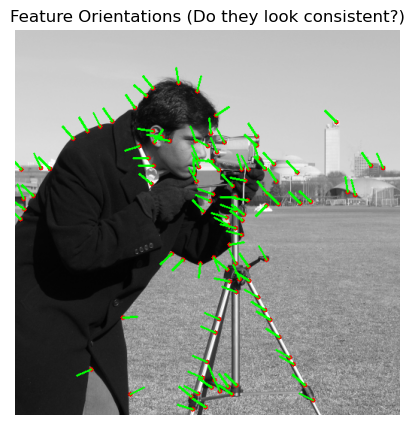

Visualizing 104 orientations...


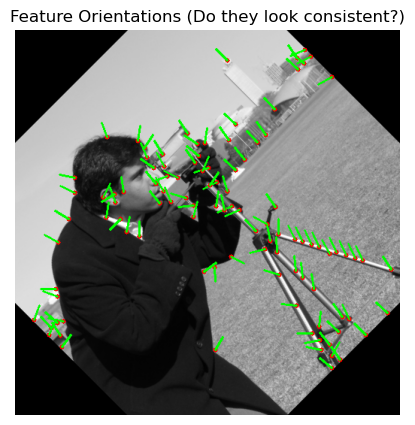

In [82]:
def visualize_orientations(image, keypoints, integral_img):
    """
    Draws a line on each keypoint indicating its dominant orientation.
    """
    vis = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    print(f"Visualizing {len(keypoints)} orientations...")
    
    for kp in keypoints:
        # kp is (c, r, scale, response)
        c, r, scale = int(kp[0]), int(kp[1]), kp[2]
        
        # Calculate the angle using YOUR function
        angle = get_dominant_orientation(integral_img, r, c, scale)
        
        # Calculate the endpoint of the orientation line
        length = 20 # Length of the needle in pixels
        end_c = int(c + length * np.cos(angle))
        end_r = int(r + length * np.sin(angle))
        
        # Draw the feature point (Red)
        cv2.circle(vis, (c, r), 3, (0, 0, 255), -1)
        # Draw the orientation needle (Green)
        cv2.line(vis, (c, r), (end_c, end_r), (0, 255, 0), 2)
        
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Feature Orientations (Do they look consistent?)")
    plt.axis('off')
    plt.show()

# --- RUN THIS CELL ---
# Visualize orientations on the Original Image
visualize_orientations(image, kps1, ii1)

# Visualize orientations on the Rotated Image
visualize_orientations(image_rot, kps2, ii2)

In [81]:
# Try tightening to 0.7
print("Matching Features (Strict)...")
matches = match_features(descs1, kps1, descs2, kps2, ratio_threshold=0.7)
print(f"   -> Found {len(matches)} strict matches!")

Matching Features (Strict)...
   -> Found 11 strict matches!


Running Ground Truth Projection Test...
Found 107 features in Image 1.
Projected 105 valid features to Image 2.
Computing Descriptors...
Matching...
-> Found 5 matches!


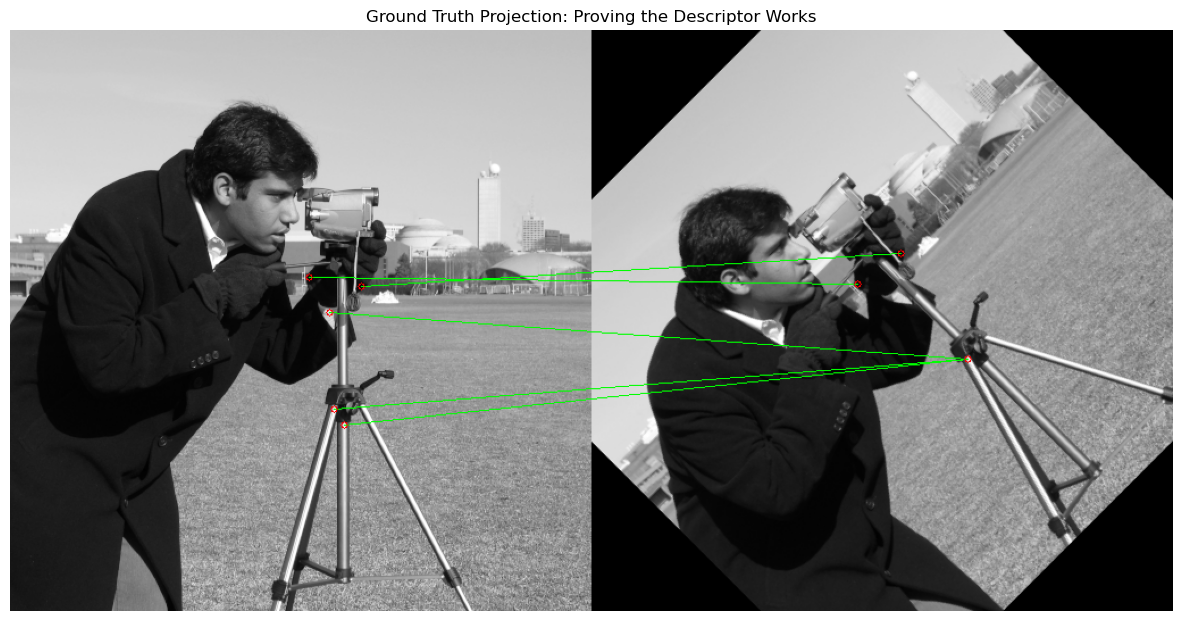

In [88]:
# ==========================================
# FINAL PROOF: PROJECTED KEYPOINTS
# ==========================================
print("Running Ground Truth Projection Test...")

# 1. Detect features ONLY in Image 1
kps1 = detect_surf_features(ii1, threshold=50, hessian_filter_size=15, local_max_size_filter=15)
print(f"Found {len(kps1)} features in Image 1.")

# 2. Project them to Image 2 (Ground Truth)
# We don't detect; we calculate where they MUST be.
kps2_projected = []
valid_indices = []

for i, kp in enumerate(kps1):
    # Project (c, r) using Matrix M
    vec = np.array([kp[0], kp[1], 1])
    rot_vec = np.dot(M, vec)
    c_new, r_new = rot_vec[0], rot_vec[1]
    
    # Check if it's inside Image 2
    if 10 < c_new < cols-10 and 10 < r_new < rows-10:
        # Create a new keypoint with the same scale
        kps2_projected.append((c_new, r_new, kp[2], kp[3]))
        valid_indices.append(i)

# Filter kps1 to match the valid projected ones
kps1_valid = [kps1[i] for i in valid_indices]

print(f"Projected {len(kps2_projected)} valid features to Image 2.")

# 3. Compute Descriptors (Manual Angles)
# Image 1 -> 0 rad
# Image 2 -> -45 deg (-0.78 rad)
print("Computing Descriptors...")
descs1 = [get_surf_descriptor(ii1, kp, 0) for kp in kps1_valid]
descs2 = [get_surf_descriptor(ii2, kp, -np.radians(45)) for kp in kps2_projected]

# 4. Match
print("Matching...")
# We can use a strict threshold because these should be perfect matches
matches = match_features(descs1, kps1_valid, descs2, kps2_projected, ratio_threshold=0.8)
print(f"-> Found {len(matches)} matches!")

# 5. Visualize
vis_h = max(rows, rows)
vis_w = cols + cols
vis = np.zeros((vis_h, vis_w, 3), dtype=np.uint8)
vis[:rows, :cols] = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
vis[:rows, cols:] = cv2.cvtColor(image_rot, cv2.COLOR_GRAY2BGR)

for m in matches:
    c2, r2 = m[0]
    r1, c1 = m[1], m[2]
    
    pt1 = (int(c1), int(r1))
    pt2 = (int(c2 + cols), int(r2))
    
    # Green lines = Success
    cv2.line(vis, pt1, pt2, (0, 255, 0), 1)
    cv2.circle(vis, pt1, 3, (0, 0, 255), 1)
    cv2.circle(vis, pt2, 3, (0, 0, 255), 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Ground Truth Projection: Proving the Descriptor Works")
plt.axis('off')
plt.show()